## Group gene expression by time

In [1]:
import os
import re
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

### *Step 1: read all raw data*

In [9]:
DATA_PATH = r'../dataset/'
genexp_df = None
mapper = lambda x : x[1:]
genes = ["amon","brp","cac","Cadps","Fife","Liprin-alpha","Pdf","Rab27","Rab3",
         "Rbp","RhoGAP100F","Rim","Snap25","Syb","Syt1","Syt12","Syt14","Syt4",
         "Syt7","Sytalpha","Sytbeta","Syx13","Syx16","Syx17","Syx18","Syx4",
         "Syx5","Syx6","Syx7","Syx8","unc-13"]
# couldn't find syx1A in dataset...

In [10]:
for filename in os.listdir(DATA_PATH):
    new_df = pd.read_csv(os.path.join(DATA_PATH, filename), index_col=0).loc[genes]
    new_df = new_df.rename(mapper, axis='columns').T
    if genexp_df is None:
        genexp_df = new_df
        continue
    genexp_df = pd.concat([genexp_df, new_df])
genexp_df

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx13,Syx16,Syx17,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,1,0,0,0,0,2,7,1,0,16
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,0,0,0,0,1,2,0,25
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_TGGTGA,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20190309_CLK856_LD_ZT22_AR02_TGGTTG,0,1,0,3,0,0,19,0,1,2,...,0,0,0,0,0,0,0,0,0,5
20190309_CLK856_LD_ZT22_AR02_TGTCAC,2,5,13,9,0,4,60,0,4,4,...,1,0,0,0,0,1,0,1,0,11
20190309_CLK856_LD_ZT22_AR02_TGTCGA,0,0,0,2,0,0,284,0,0,1,...,0,0,0,0,0,0,0,0,1,3


### *Step 2: extract date, experiment type, and time for each neuron*

In [36]:
def get_date(neuron: str) -> date:
    """
    Extracts date data from singular index
    :param neuron: string representing single neuron
    :return: date data
    """
    date_pattern = re.compile(r'(20\d\d)(\d\d)(\d\d)')
    match = date_pattern.search(neuron)
    if not match:
        raise ValueError(f'Date not found in {neuron}')
    year, month, day = tuple([int(x) for x in match.groups()])
    if month == 0:
        month = 1
    return date(year, month, day)


def get_exp(neuron: str) -> str:
    """
    Get experiment (DD || LD) applied to the neuron
    :param neuron:
    :return: string 'DD' or 'LD'
    """
    exp_re = re.compile(r"(_)(DD|LD)(_)")
    match = exp_re.search(neuron)
    if not match:
        raise ValueError(f'Experiment not found in {neuron}')
    return match.group(2)


def get_time(neuron: str) -> str:
    """
    Same as above, capturing ZT or CT time
    :param neuron: single neuron name
    :return: ZTXX or CTXX
    """
    time_pattern = re.compile(r'(CT|ZT)(\d\d)')
    match = time_pattern.search(neuron)
    if not match:
        raise ValueError(f'Time not found in {neuron}')
    return match.group()


test_str = '20190528_CLK856_DD_CT02_AR05_ACGTAC'
exp_date = get_date(test_str)
experiment = get_exp(test_str)
exp_time = get_time(test_str)
print(f"{exp_date=}")
print(f"{experiment=}")
print(f"{exp_time=}")

exp_date=datetime.date(2019, 5, 28)
experiment='DD'
exp_time='CT02'


In [39]:
indeces = genexp_df.index.to_series()
genexp_df['date'] = indeces.map(get_date)
genexp_df['experiment'] = indeces.map(get_exp)
genexp_df['exp_time'] = indeces.map(get_time)
genexp_df

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,experiment,exp_time
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,0,0,2,7,1,0,16,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,0,1,2,0,25,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,0,1,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_TGGTGA,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,2019-03-09,LD,ZT22
20190309_CLK856_LD_ZT22_AR02_TGGTTG,0,1,0,3,0,0,19,0,1,2,...,0,0,0,0,0,0,5,2019-03-09,LD,ZT22
20190309_CLK856_LD_ZT22_AR02_TGTCAC,2,5,13,9,0,4,60,0,4,4,...,0,0,1,0,1,0,11,2019-03-09,LD,ZT22
20190309_CLK856_LD_ZT22_AR02_TGTCGA,0,0,0,2,0,0,284,0,0,1,...,0,0,0,0,0,1,3,2019-03-09,LD,ZT22


### *Step 3: group by experiment (for instance, keep 'DD')*

In [43]:
genexp_df_DD = genexp_df[genexp_df['experiment'] == 'DD']
genexp_df_DD

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,experiment,exp_time
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,0,0,2,7,1,0,16,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,0,1,2,0,25,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,0,1,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190704_CLK856_DD_CT22_AR14_TGGTGA,7,1,2,3,4,0,3,0,5,6,...,0,0,0,0,0,0,2,2019-07-04,DD,CT22
20190704_CLK856_DD_CT22_AR14_TGGTTG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2019-07-04,DD,CT22
20190704_CLK856_DD_CT22_AR14_TGTCAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2019-07-04,DD,CT22
20190704_CLK856_DD_CT22_AR14_TGTCGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2019-07-04,DD,CT22


In [2]:
genexp_df_DD.to_csv('genexp_dd.csv')

NameError: name 'genexp_df_DD' is not defined

### *Step 4: group by time*

In [8]:
genexp_df_DD = pd.read_csv('genexp_dd.csv', index_col=0)
genexp_df_DD

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,experiment,exp_time
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,0,0,2,7,1,0,16,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,0,1,2,0,25,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,0,1,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190704_CLK856_DD_CT22_AR14_TGGTGA,7,1,2,3,4,0,3,0,5,6,...,0,0,0,0,0,0,2,2019-07-04,DD,CT22
20190704_CLK856_DD_CT22_AR14_TGGTTG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2019-07-04,DD,CT22
20190704_CLK856_DD_CT22_AR14_TGTCAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2019-07-04,DD,CT22
20190704_CLK856_DD_CT22_AR14_TGTCGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2019-07-04,DD,CT22


In [32]:
count_df = genexp_df_DD[genexp_df_DD != 0]\
                        .drop(['date', 'experiment'], axis='columns')\
                        .groupby('exp_time')\
                        .count().T

In [33]:
mean_df = genexp_df_DD\
                        .drop(['date', 'experiment'], axis='columns')\
                        .groupby('exp_time')\
                        .mean().T

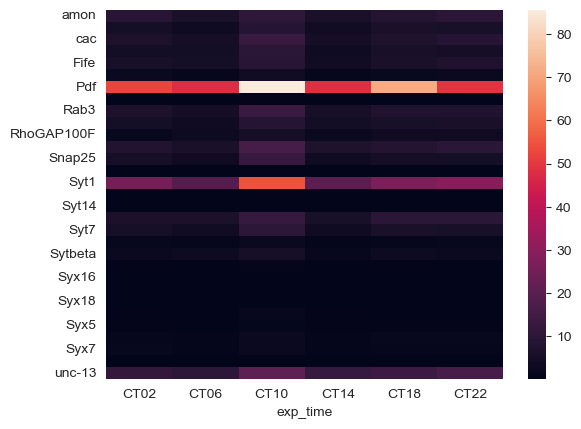

In [34]:
sns.heatmap(mean_df);

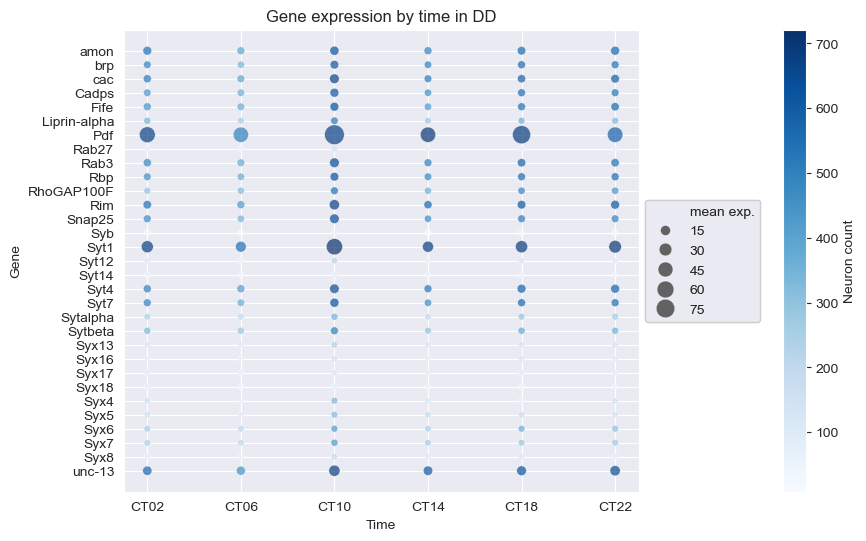

In [65]:
# melt and combine dataframes
count_melted = count_df.reset_index().melt(id_vars='index', var_name='column', value_name='cell count')
mean_melted = mean_df.reset_index().melt(id_vars='index', var_name='column', value_name='mean exp.')
merged_df = pd.merge(count_melted, mean_melted, on=['index', 'column'])

# create dot plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = sns.scatterplot(data=merged_df, x='column', y='index', size='mean exp.', hue='cell count',
                          palette='Blues', sizes=(20, 200), legend='brief', edgecolor='w', alpha=0.7)

# create a colorbar
norm = plt.Normalize(count_df.values.min(), count_df.values.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter.axes, pad=0.02)
cbar.set_label('Neuron count')

# legend with scales
handles, labels = scatter.get_legend_handles_labels()
box = scatter.get_position()
scatter.set_position([box.x0, box.y0, box.width * 0.8, box.height])
size_legend = plt.legend(handles[-len(mean_df.columns):], labels[-len(mean_df.columns):],
                         loc="center right", bbox_to_anchor=(1.25, 0.5), frameon=True)
plt.gca().add_artist(size_legend)

# titles and labels
plt.title('Gene expression by time in DD')
plt.xlabel('Time')
plt.ylabel('Gene')
plt.savefig('genexp_dd_dotplot.png')
plt.show()